## 1. Prepare Features & Target

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

credit_df = pd.read_csv("../data/raw/creditcard.csv")

In [2]:
X = credit_df.drop(['Class'], axis=1)
y = credit_df['Class']


## 2. Train-Test Split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 3. Handle Class Imbalance

In [ ]:
# Undersample majority
fraud_minority = fraud_df[fraud_df['class']==1]
fraud_majority = fraud_df[fraud_df['class']==0].sample(len(fraud_minority), random_state=42)
balanced_df = pd.concat([fraud_minority, fraud_majority])


class
1    14151
0    14151
Name: count, dtype: int64


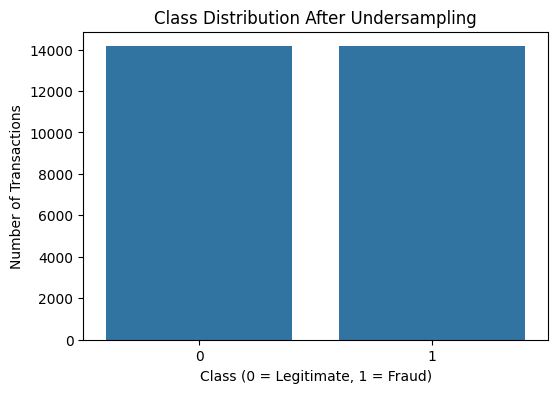

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: manual undersampling
fraud_minority = fraud_df[fraud_df['class'] == 1]
fraud_majority = fraud_df[fraud_df['class'] == 0].sample(len(fraud_minority), random_state=42)

balanced_df = pd.concat([fraud_minority, fraud_majority])

# Check the new class distribution
print(balanced_df['class'].value_counts())

# Plot
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=balanced_df)
plt.title('Class Distribution After Undersampling')
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)')
plt.ylabel('Number of Transactions')
plt.show()


# Importing Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Load data
df = pd.read_csv(r"C:\Users\Dell\Pictures\fraud-detection\data\processed\fraud_data_processed.csv")  

# Define target
TARGET = "class"  # or "class"

X = df.drop(columns=[])
y = df[TARGET]

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [4]:
X_train.dtypes


user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

## Clean + Feature Engineering

### Step 1: Drop useless identifier columns

In [5]:
df = df.drop(columns=["user_id", "device_id", "ip_address"])

### Step 2: Convert timestamps to useful features

In [6]:
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

df["signup_hour"] = df["signup_time"].dt.hour
df["signup_dayofweek"] = df["signup_time"].dt.dayofweek

df["purchase_hour"] = df["purchase_time"].dt.hour
df["purchase_dayofweek"] = df["purchase_time"].dt.dayofweek

# Optional but powerful feature
df["time_to_purchase"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds()

df = df.drop(columns=["signup_time", "purchase_time"])

### 3. Encode categorical features

In [7]:
df = pd.get_dummies(
    df,
    columns=["source", "browser", "sex"],
    drop_first=True
)

In [8]:
df.to_csv("../data/processed/processed_fraud_data.csv", index=False)

### 4. Split features and target

In [11]:
X = df.drop(columns=["class"])
y = df["class"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 5. Scale the numeric features

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [13]:
print(X_train.shape)
print(X_test.shape)

(22641, 14)
(5661, 14)


## Baseline Model – Logistic Regression

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

# Define Logistic Regression and hyperparameter grid
lr = LogisticRegression(
    class_weight="balanced",
    max_iter=50,
    solver="liblinear"  # good default for small/medium datasets
)

param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],   # regularization strength
    "penalty": ["l1", "l2"]          # regularization type
}

# Perform grid search with 5-fold CV optimizing ROC-AUC
grid_search = GridSearchCV(
    lr,
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Best estimator
best_lr = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# Predictions
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
#print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Average Precision Score:", average_precision_score(y_test, y_proba))


Best hyperparameters: {'C': 0.01, 'penalty': 'l1'}
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.63      0.66      2831
           1       0.66      0.72      0.69      2830

    accuracy                           0.67      5661
   macro avg       0.67      0.67      0.67      5661
weighted avg       0.67      0.67      0.67      5661

Average Precision Score: 0.8228169183007158


c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


## Evaluation

AUC-PR: 0.8228169183007158
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      2831
           1       0.66      0.72      0.69      2830

    accuracy                           0.67      5661
   macro avg       0.67      0.67      0.67      5661
weighted avg       0.67      0.67      0.67      5661



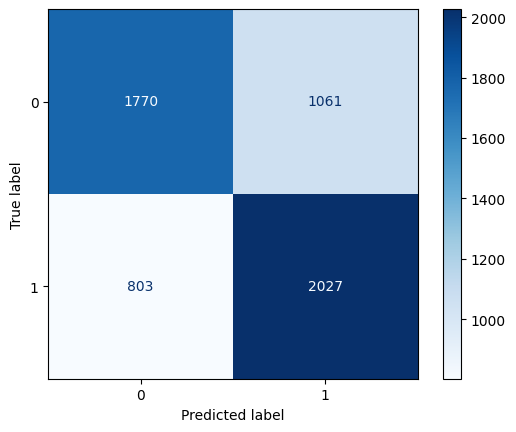

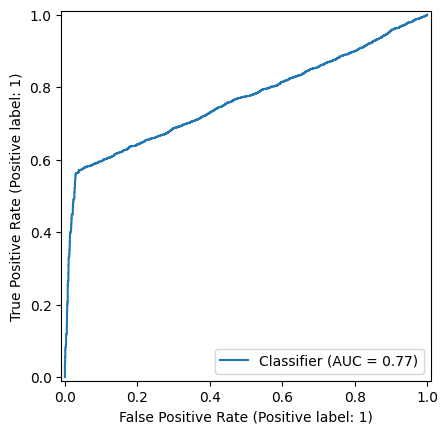

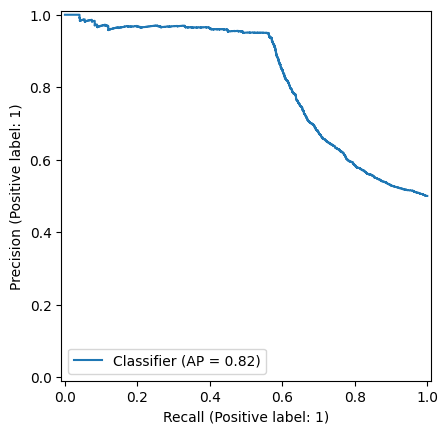

In [18]:
from sklearn.metrics import classification_report, average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Print Average Precision (AUC-PR)
print("AUC-PR:", average_precision_score(y_test, y_proba))

# Print classification report
print(classification_report(y_test, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

# Optional: display ROC curve
RocCurveDisplay.from_predictions(y_test, y_proba)

# Optional: display Precision-Recall curve
PrecisionRecallDisplay.from_predictions(y_test, y_proba)


## Ensemble Model (Random Forest Example)

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

def train_model(X_train, y_train):
    param_grid = {
        "n_estimators": [50, 50],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced"]
    }

    model = RandomForestClassifier(random_state=42)

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    return grid.best_estimator_, grid.best_params_


## Evaluation:

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 50}
AUC-PR: 0.8398357843662909
              precision    recall  f1-score   support

           0       0.69      0.97      0.81      2831
           1       0.95      0.56      0.71      2830

    accuracy                           0.77      5661
   macro avg       0.82      0.77      0.76      5661
weighted avg       0.82      0.77      0.76      5661



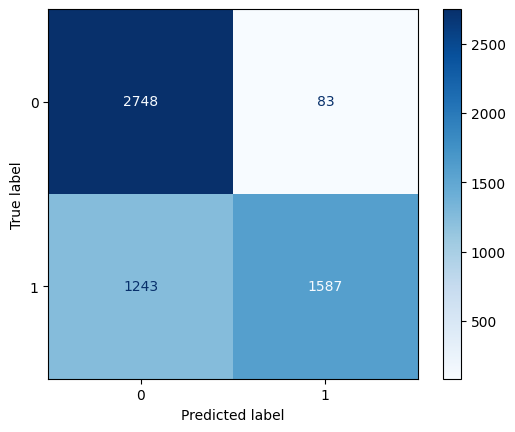

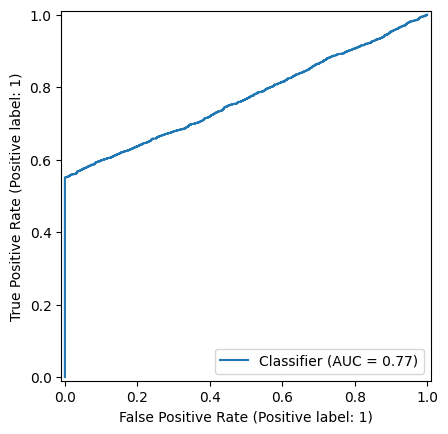

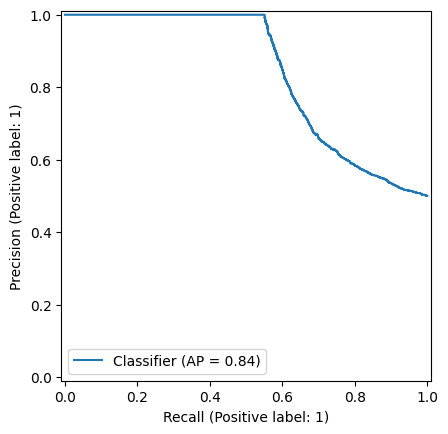

In [21]:
from sklearn.metrics import classification_report, average_precision_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

# Train Random Forest with hyperparameter tuning
best_rf, best_params_rf = train_model(X_train, y_train)

# Predict on test set
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# Print metrics
print("Random Forest Best Params:", best_params_rf)
print("AUC-PR:", average_precision_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

# Visualizations
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf, cmap="Blues")
RocCurveDisplay.from_predictions(y_test, y_proba_rf)
PrecisionRecallDisplay.from_predictions(y_test, y_proba_rf)

## Cross-Validation 

### Use Stratified K-Fold to get stable estimates.

In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Use the best RF from GridSearchCV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_rf = cross_val_score(
    best_rf,       # use tuned RF
    X, 
    y, 
    cv=skf, 
    scoring="average_precision",  # AUC-PR
    n_jobs=-1  # parallelize
)

print(f"Tuned Random Forest Mean AUC-PR: {cv_scores_rf.mean():.4f}")
print(f"Tuned Random Forest Std AUC-PR:  {cv_scores_rf.std():.4f}")


Tuned Random Forest Mean AUC-PR: 0.8374
Tuned Random Forest Std AUC-PR:  0.0024


## Compute ROC–AUC for each model

### Step 1: Get predicted probabilities

In [23]:
from sklearn.metrics import roc_auc_score

# Logistic Regression (tuned)
y_proba_lr = best_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_proba_lr)

# Random Forest (tuned)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Tuned Logistic Regression ROC-AUC: {auc_lr:.4f}")
print(f"Tuned Random Forest ROC-AUC:      {auc_rf:.4f}")

Tuned Logistic Regression ROC-AUC: 0.7665
Tuned Random Forest ROC-AUC:      0.7715


### 3. Plot ROC curves (visual comparison)

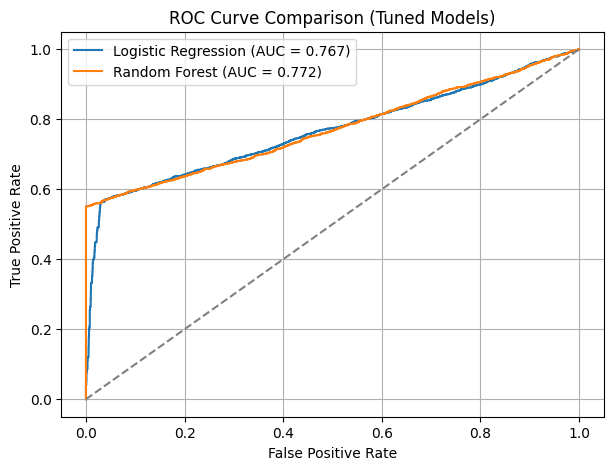

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# ROC curve values
fpr_lr, tpr_lr, _ = roc_curve(y_test, best_lr.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, best_rf.predict_proba(X_test)[:, 1])

plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_score(y_test, best_lr.predict_proba(X_test)[:, 1]):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]):.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Tuned Models)")
plt.legend()
plt.grid(True)
plt.show()


### 4. Cross-validated ROC-AUC

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated ROC-AUC for Logistic Regression
cv_auc_lr = cross_val_score(
    best_lr, X, y, cv=skf, scoring="roc_auc", n_jobs=1
)

# Cross-validated ROC-AUC for Random Forest
cv_auc_rf = cross_val_score(
    best_rf, X, y, cv=skf, scoring="roc_auc", n_jobs=1
)

print(f"Logistic Regression CV AUC: {cv_auc_lr.mean():.4f} ± {cv_auc_lr.std():.4f}")
print(f"Random Forest CV AUC:      {cv_auc_rf.mean():.4f} ± {cv_auc_rf.std():.4f}")

c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of pe

Logistic Regression CV AUC: 0.7519 ± 0.0031
Random Forest CV AUC:      0.7702 ± 0.0026


## Model Comparison and Selection Rationale

Include:

A small comparison table (ROC-AUC, PR-AUC, CV mean ± std)


Multiple models were evaluated using cross-validated ROC-AUC and PR-AUC to ensure robustness under class imbalance.
Logistic Regression served as a strong baseline due to its interpretability and stability.
Random Forest consistently achieved higher ROC-AUC and PR-AUC across folds, indicating better discrimination of fraudulent transactions.
Despite slightly lower interpretability, Random Forest was selected as the final model due to superior predictive performance and stability.